In [1]:
# Imports

import requests
import json as js
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

#import ipywidgets as widgets
#from IPython.display import display


In [2]:
# Inputs

def input_define():
    input_dict = {}
    
    # input declaring
    """     
    start_year = widgets.Text(
    placeholder='Type something',
    description='String:',
    disabled=False
    )
    end_year = widgets.Text(
    placeholder='Type something',
    description='String:',
    disabled=False
    )
    start_year = str(start_year)
    end_year = str(end_year)
    time_period = widgets.Dropdown(options=['year', 'month', 'day'])
    
    display(start_year)
    display(end_year)
    display(time_period) 
    """
    
    print('data to download available from 2002-01-02 to today.\n')
    start_year = input('start year (format YYYY-MM-DD): ')
    end_year = input('end year (format YYYY-MM-DD): ')
    time_period = input('group data by: day/week/month/year: ')

    
    # string to date
    #start_year = pd.to_datetime(start_year).date()
    #end_year = pd.to_datetime(end_year).date()
    
    # add input to dict
    input_dict['time_period'] = time_period
    input_dict['start_year'] = start_year
    input_dict['end_year'] = end_year
    
    return(input_dict)

def choose_currency_code():
    currency_choose_input = input('\nEnter currency codes after coma, format: USD, EUR etc...: ')
    currency_choose_input = currency_choose_input.replace(' ', '')
    currency_choose_input = currency_choose_input.upper()
    currency_choose_input = currency_choose_input.split(',')
    
    return currency_choose_input

In [3]:
def api_date_limit_bypass(start_date='2020-01-01', end_date='2020-03-01'):
    
    date_period_dict = {}
    start_date=pd.to_datetime(start_date).date()
    end_date=pd.to_datetime(end_date).date()
    
    # check if api bypass is needed
    if end_date - start_date > timedelta(days=90):

        # do untill end_date + 90 days will be greater than start_date
        next_date_period = 0
        while end_date > start_date:

            # add 90 days to create new end date for beeing in api limit
            end_date_new = start_date + timedelta(days=90)

            # check if new end date is greater than original end date
            if end_date_new > end_date:
                end_date_new = end_date

            # create list with start and end date for each next +90 days
            l_start_end = []
            l_start_end.append(str(start_date))
            l_start_end.append(str(end_date_new))
            
            next_date_period_key = str(next_date_period)
            date_period_dict[next_date_period_key] = l_start_end
            
            next_date_period += 1
            start_date += timedelta(days=91)
    else:
        date_period_dict['0'] = [start_date, end_date]
        
    return date_period_dict

In [4]:
def download_data(date_period_dict):
    # download data for each start/end date
    
    l_web_content = []
    for date_range in date_period_dict:
        url = 'http://api.nbp.pl/api/exchangerates/tables/a/{0}/{1}/?format=json'.format(date_period_dict[date_range][0], 
                                                                                         date_period_dict[date_range][1])

        result = requests.get(url)
        api_content = js.loads(result.content)
        
        for range_df in api_content:
            l_web_content.append(range_df)

        
            
    return l_web_content
            
def assing_data_frame_to_year(l_web_content):
    dict_of_year_data_frame = {}
    
    df_num = 0
    while df_num < len(l_web_content):
        pd_data_frame = pd.DataFrame(l_web_content[df_num]['rates'])
        dict_of_year_data_frame[l_web_content[df_num]['effectiveDate']] = pd_data_frame
        df_num += 1
        
    for year in list(dict_of_year_data_frame):
        dict_of_year_data_frame[year]['year'] = pd.to_datetime(year)
        
    return dict_of_year_data_frame


def concat_all_data_frames(dict_of_year_data_frame):
    frames = []
    for df_i in dict_of_year_data_frame:
        frames.append(dict_of_year_data_frame[df_i])

    return frames
        
    
def currency_choose(list_currency, dict_of_year_data_frame):
    list_of_currency = []
    for cur in list_currency:
        print('downloading data, please wait...')
        for df_i in dict_of_year_data_frame:
            list_of_currency.append(dict_of_year_data_frame[df_i][dict_of_year_data_frame[df_i]['code'] == cur])
    return list_of_currency   

In [5]:
def groupby_cur(filter_currency, time_period):
    groupby_result = None
    name_list = []

    day_list = ['year', 'month', 'day', 'code']
    month_list = ['year', 'month', 'code']
    year_list = ['year', 'code']

    if time_period == 'day':
        groupby_result = filter_currency.groupby([(filter_currency.year.dt.year),
                                                  (filter_currency.year.dt.month),
                                                  (filter_currency.year.dt.day),
                                                  (filter_currency.code)])['mid'].mean()
        name_list = day_list

    elif time_period == 'month':
        groupby_result = filter_currency.groupby([(filter_currency.year.dt.year),
                                                  (filter_currency.year.dt.month),
                                                  (filter_currency.code)])['mid'].mean()
        name_list = month_list

    elif time_period == 'year':
        groupby_result = filter_currency.groupby([(filter_currency.year.dt.year),
                                                  (filter_currency.code)])['mid'].mean()
        name_list = year_list
        
        
    def set_key_to_value():
        result_list = []

        for col_group in groupby_result.to_dict():
            filter_dict = {}
            col_key = 0
            while col_key < len(col_group):
                for col_name in col_group:
                    filter_dict[name_list[col_key]] = col_name
                    col_key += 1
            filter_dict['mid'] = groupby_result[col_group]
            filter_dict['mid'] = round(filter_dict['mid'], 2)
            result_list.append(filter_dict)

        if time_period == 'day':
            for i in result_list:
                i['date'] = pd.to_datetime('{0}-{1}-{2}'.format(i['year'], i['month'], i['day'])).date()
                del i['year']
                del i['month']
                del i['day']

        elif time_period == 'month':
            for i in result_list:
                i['date'] = '{0}-{1}'.format(i['year'], i['month'])
                del i['year']
                del i['month']
                2020 - 1
                if len(i['date']) == 6:
                    i['date'] = pd.to_datetime('{0}0{1}'.format(i['date'][0:5], i['date'][-1]))

        elif time_period == 'year':
            for i in result_list:
                i['date'] = '{0}'.format(i['year'])
                del i['year']

        return result_list

    return set_key_to_value()

In [6]:
def display_graph(list_of_df, input_date_period):
    print('\ncreating graph...')

    main_df = pd.DataFrame(list_of_df)
    
    plt.style.use('seaborn')
    main_df.set_index('date', inplace=True)
    main_df.groupby('code')['mid'].plot(legend=True, subplots=False, figsize=(10, 6), 
                                        linewidth=3, alpha=0.7, title='Changes in average currency values over time')
    
    plt.xlabel('Date between {0} and {1}'.format(input_date_period['start_year'], input_date_period['end_year']))
    plt.ylabel('Average currency value in PLN')
    
    plt.show()

program is running
data to download available from 2002-01-02 to today.



downloading data, please wait...

creating graph...


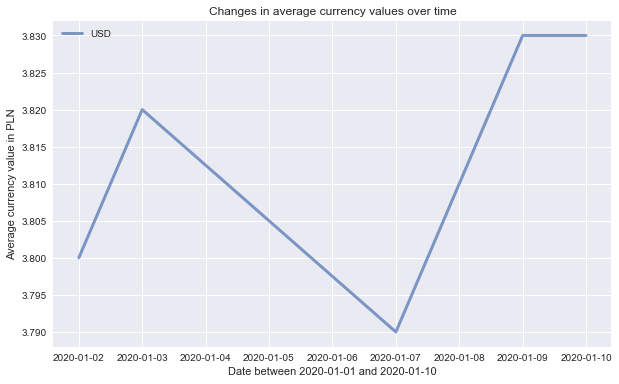

In [7]:
def init():
    print('program is running')
    
    input_get = input_define()
    date_bypass = api_date_limit_bypass(input_get['start_year'], input_get['end_year'])

    print('\n')
    data_get = download_data(date_bypass)
    
    assingn_data_to_df = assing_data_frame_to_year(data_get)
    concat_df = concat_all_data_frames(assingn_data_to_df)
    
    cur_input = choose_currency_code()
    cur_choose = currency_choose(cur_input, assingn_data_to_df)
    
    filter_currency = pd.concat(cur_choose)
    
    currency_group_by = groupby_cur(filter_currency, input_get['time_period'])
    
    display_graph(currency_group_by, input_get)
init()

In [ ]:
# DOWNLOAD HISTORICAL DATA TEST

from selenium.webdriver import Chrome
from selenium.webdriver.common.keys import Keys

from bs4 import BeautifulSoup
import requests

url = 'https://www.nbp.pl/home.aspx?f=/kursy/arch_a.html'
result = requests.get(url)
soup = BeautifulSoup(result.content)
summary = soup.find('td',{'class': 'normal_2'})
a_list = summary.find_all('a')
print(a_list[0]["href"])

hist_input_start = input('choose start data format:(YYYY): ')
hist_input_end = input('choose end data format:(YYYY): ')
historical_data_range = (int(hist_input_start), int(hist_input_end))

for a_href in a_list:
    for year in historical_data_range:
        if str(year) in a_href:
            driver = Chrome(executable_path="C://Users//StanislawAniola//Downloads//chromedriver_win32//chromedriver.exe")
            driver.get('https://www.nbp.pl/home.aspx?f=/kursy/arch_a.html')
            x = '//a[contains(@href,"{0}")]'.format(a_href["href"])
            button = driver.find_element_by_xpath(x)
            button.send_keys(Keys.CONTROL + 't')
            #button.click()
